In [13]:
import sys, qiskit
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state, random_circuit
from qsee.backend import constant, utilities
from qsee.evolution import crossover, mutate, selection, threshold
from qsee.evolution.environment import EEnvironment, EEnvironmentMetadata
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_89651/356136188.py:15: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(i, i+1)
/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_89651/356136188.py:26: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(i, i+1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new defau

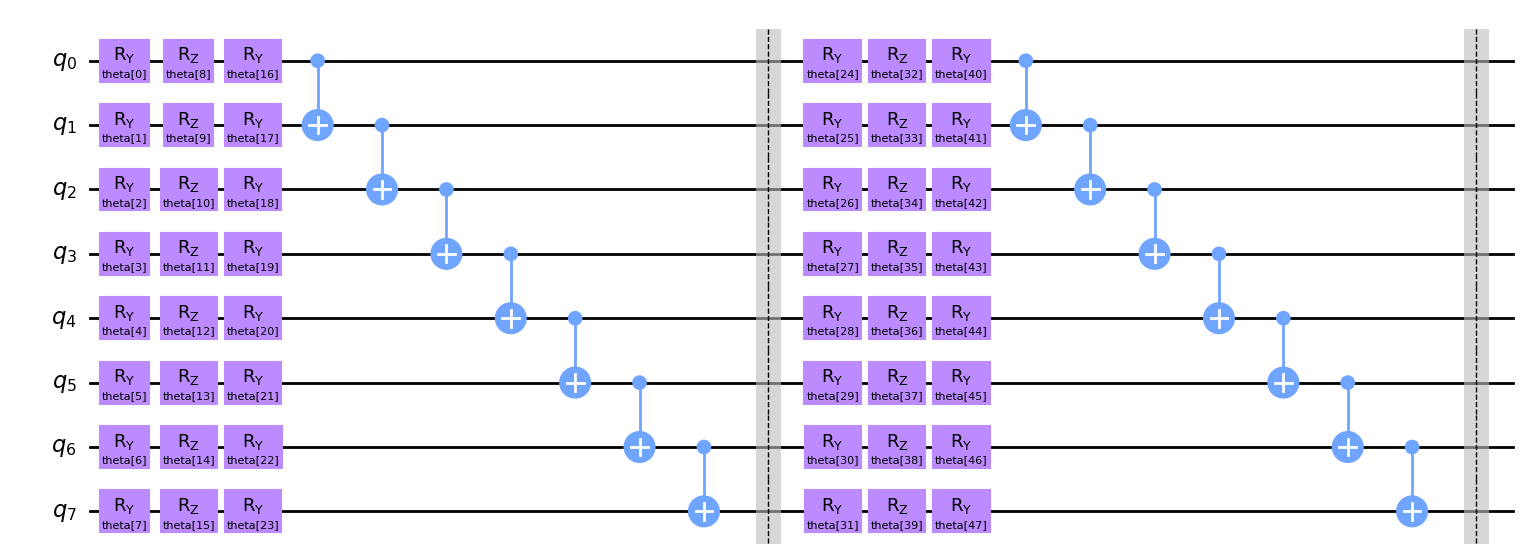

In [14]:
n_qubits=8
n=3
theta = qiskit.circuit.ParameterVector('theta',2*n*n_qubits)
#theta = np.random.rand(n*n_qubits)
#print(theta)
qc = qiskit.QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.ry(theta[i], i)
for i in range(n_qubits):
    qc.rz(theta[i+n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+2*n_qubits], i)

for i in range(n_qubits-1):
    qc.cnot(i, i+1)
qc.barrier()

for i in range(n_qubits):
    qc.ry(theta[i+3*n_qubits], i)
for i in range(n_qubits):
    qc.rz(theta[i+4*n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+5*n_qubits], i)

for i in range(n_qubits-1):
    qc.cnot(i, i+1)
qc.barrier()

qc.draw('mpl')

In [15]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import L_BFGS_B, SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.units import DistanceUnit
from qiskit.utils import algorithm_globals

optimizer = SLSQP(maxiter=60)
estimator = Estimator()
#algorithm_globals.random_seed = 50

driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.6",
        basis="631g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
algorithm_globals.random_seed = 50

mapper=JordanWignerMapper()
qubit_op = mapper.map(hamiltonian)


vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
ene_vqe = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
print(ene_vqe)

overwrite output file: /var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/tmpixbbymu6.log


/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_89651/3246759979.py:22: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 50


-1.9919926790039644


In [16]:
optimizers = [L_BFGS_B(maxiter=50), SLSQP(maxiter=50)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

def vqe_convergence(qc):
    for i, optimizer in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
        algorithm_globals.random_seed = 50
        ansatz = qc

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)

        vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer, callback=store_intermediate_result)
        #vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
        #          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(qubit_op)
        print(result.eigenvalue)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)
    return converge_cnts, converge_vals

Optimizer: L_BFGS_B        

/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_89651/222479495.py:8: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 50


-1.991573306307132
Optimizer: SLSQP        

/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_89651/222479495.py:8: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 50


-1.9919926790039644


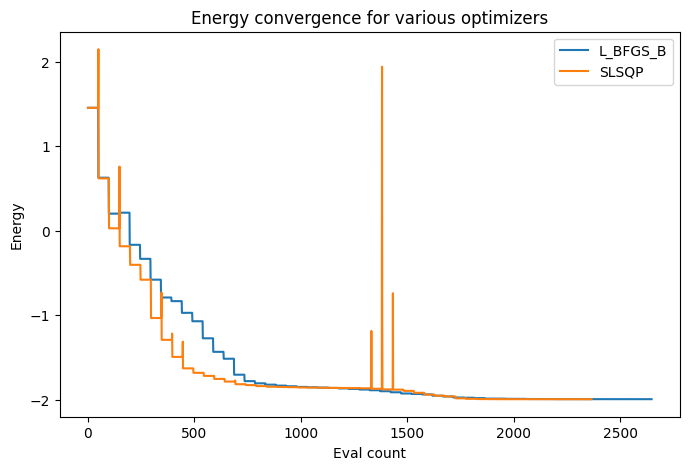

In [17]:
import pylab

converge_cnts, converge_vals = vqe_convergence(qc)
pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

In [11]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit.utils import algorithm_globals


def VQE_fitness(qc: qiskit.QuantumCircuit, atom: str, basis: str):

    driver = PySCFDriver(
        atom=atom,
        basis=basis,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()

    optimizer = SLSQP(maxiter=40)
    estimator = Estimator()
    algorithm_globals.random_seed = 50
    
    mapper=JordanWignerMapper()
    qubit_op = mapper.map(hamiltonian)
    vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
    ene = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue
    return ene
print(ene_vqe)

-1.8819818575778102


In [30]:
params = {'depth': 3,
          'num_circuit': 8,  # Must mod 8 = 0
          'num_generation': 6,
          'num_qubits': 8,
          'threshold': thres,
          'prob_mutate': 0.1}

env = environment.EEnvironment(
    params,
    fitness_func = VQE_fitness,
    selection_func = selection.elitist_selection,
    crossover_func= crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool = qsee.constant.operations
)

#env.initialize_population()
env.evol() 

Step:   0%|          | 0/6 [00:00<?, ?it/s]

Initialize population ...
overwrite output file: /tmp/tmpqyzy2stm.log
-1.0058334910090558
overwrite output file: /tmp/tmpd82u6xi4.log
-1.0058334675516878
overwrite output file: /tmp/tmpj99beaki.log
-1.2346266113926458
overwrite output file: /tmp/tmprcpvfj_j.log
-1.2346266114312927
overwrite output file: /tmp/tmp57dtlbqe.log
-1.5042476452482285
overwrite output file: /tmp/tmpk560ifq0.log
-1.504247645386609
overwrite output file: /tmp/tmpm6e40b8w.log
-0.2371803057899364
overwrite output file: /tmp/tmpe9upif22.log
-0.23717279882981163
overwrite output file: /tmp/tmpj_oa_45c.log
-1.8820900923481112
overwrite output file: /tmp/tmp93evnbgq.log
-1.8820905715994738
overwrite output file: /tmp/tmpjjpa4plx.log
-1.8820902393861234
overwrite output file: /tmp/tmp5r38as7b.log
-1.882090524673584
overwrite output file: /tmp/tmpe22syola.log
-1.7575535789072385
overwrite output file: /tmp/tmp_nsaspo3.log
-1.7575535788479482
overwrite output file: /tmp/tmpajcppzbi.log
-0.23815945753805418
overwrite outp

Step:  17%|█▋        | 1/6 [00:57<04:49, 57.91s/it]

-0.9182549522060942
End evol progress, best score ever: -1.882090414256846


In [33]:
converge_cnts, converge_vals = vqe_convergence(qc)

pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

Optimizer: L_BFGS_B        -1.882090605507282
Optimizer: SLSQP        -1.882090588500393
